### 1. Imports

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import gym
import numpy as np
from stable_baselines3 import PPO, A2C
from matplotlib import pyplot as plt

In [2]:
# Import classes
from rl_environment import Environment

### 2. Environment creation

#### Parameters for Simulation

In [3]:
number_of_regional_warehouses = 2
max_inventory_amount_regional_warehouses = 30
max_inventory_amount_central_warehouse = 60
customer_demand_per_step = [2,1,3]  # List needs one entry per regional warehouse 
simulation_length = 45
lead_time = 2
shipment_amount = [6, 10]  # Regarding regional warehouses
with_manufacturer = False
cw_shipment_amount = 10  # Regarding central warehosue
manufacturer_prod_capacity_per_step = 5
shipment_var_cost_per_unit = 0.05
shipment_fixed_cost = .25  # Reward penalty
inventory_holding_cost_multiplier = 1 # Standard = 1; Can be lowered; Not higher that 1
demand_fluctuation = 0
lead_time_fluctuation = 0

#### Parameters for Agent Training

In [4]:
algorithm = "A2C"  # "PPO" or "A2C"
training_steps = 30000

print("-> Equals to " + str(int(training_steps/simulation_length)) + " simulation training rounds")

-> Equals to 666 simulation training rounds


#### Creating Environment

In [5]:
env = Environment(number_of_regional_wh = number_of_regional_warehouses, 
                  rw_inventory_limit = max_inventory_amount_regional_warehouses, 
                  cw_inventory_limit = max_inventory_amount_central_warehouse,
                  demand = customer_demand_per_step,
                  sim_length = simulation_length,
                  lead_time = lead_time,
                  shipment_amount = shipment_amount,
                  manufacturer = with_manufacturer,
                  cw_shipment_amount = cw_shipment_amount,
                  mf_prod_capacity = manufacturer_prod_capacity_per_step,
                  shipment_var_cost_per_unit = shipment_var_cost_per_unit,
                  shipment_fixed_cost = shipment_fixed_cost,
                  inventory_holding_cost_multiplier = inventory_holding_cost_multiplier,
                  demand_fluctuation = demand_fluctuation,
                  lead_time_fluctuation = lead_time_fluctuation
                 )

env.print_environment_information()

Simulation created with the following parameters:
________________________________________________________________________________
Simulation | Round 1
-------------------
-> Active shipments:
No active shipments

-> Warehouses:
central_warehouse ; Inventory: 20
regional_warehouse_1 ; ID: 1 ; Inventory: 10 ; Demand: 2 ; Lost sales: 0
regional_warehouse_2 ; ID: 2 ; Inventory: 10 ; Demand: 1 ; Lost sales: 0
________________________________________________________________________________
Environment Information
-----------------------
-> Gym spaces:
Observation space: Dict(rw_inventories:MultiDiscrete([31 31]), shipments:MultiDiscrete([2 2]))
Action space: MultiDiscrete([3 3])
Starting state: {'rw_inventories': array([10, 10]), 'shipments': array([0, 0])}

-> Reward penalty per shipment size:
Shipment of 6: 0.55
Shipment of 10: 0.75
________________________________________________________________________________


### 3. RL model training

###### Model Selection
PPO (Proximal Policy Optimization)
https://openai.com/blog/openai-baselines-ppo/

A2C
https://openai.com/blog/baselines-acktr-a2c/

In [6]:
if algorithm.upper() == "PPO":
    trained_model = PPO("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "A2C":
    trained_model = A2C("MultiInputPolicy", env, verbose=1)
else:
    print("Model not found")
    exit()
trained_model.learn(total_timesteps=training_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | -9.8     |
| time/                 |          |
|    fps                | 319      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.788   |
|    explained_variance | -0.793   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.34     |
|    value_loss         | 9.06     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | -9.73    |
| time/                 |          |
|    fps                | 390      |
|    iterations         | 200      |
|    time_elapsed 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | 1.22     |
| time/                 |          |
|    fps                | 440      |
|    iterations         | 1400     |
|    time_elapsed       | 15       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -0.918   |
|    explained_variance | -0.0157  |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | 0.0359   |
|    value_loss         | 0.0856   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | 1.83     |
| time/                 |          |
|    fps                | 443      |
|    iterations         | 1500     |
|    time_elapsed       | 16       |
|    total_timesteps    | 7500     |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | 11.7     |
| time/                 |          |
|    fps                | 465      |
|    iterations         | 2800     |
|    time_elapsed       | 30       |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -0.0313  |
|    explained_variance | 0.121    |
|    learning_rate      | 0.0007   |
|    n_updates          | 2799     |
|    policy_loss        | -0.141   |
|    value_loss         | 944      |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 45        |
|    ep_rew_mean        | 12.2      |
| time/                 |           |
|    fps                | 467       |
|    iterations         | 2900      |
|    time_elapsed       | 31        |
|    total_timesteps    | 14500     |
| train/                |    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | 13.3     |
| time/                 |          |
|    fps                | 480      |
|    iterations         | 4100     |
|    time_elapsed       | 42       |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -0.00725 |
|    explained_variance | 0.999    |
|    learning_rate      | 0.0007   |
|    n_updates          | 4099     |
|    policy_loss        | 1.14e-05 |
|    value_loss         | 0.000187 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 45        |
|    ep_rew_mean        | 13.3      |
| time/                 |           |
|    fps                | 481       |
|    iterations         | 4200      |
|    time_elapsed       | 43        |
|    total_timesteps    | 21000     |
| train/                |    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | 13.4     |
| time/                 |          |
|    fps                | 488      |
|    iterations         | 5400     |
|    time_elapsed       | 55       |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -0.00311 |
|    explained_variance | 0.998    |
|    learning_rate      | 0.0007   |
|    n_updates          | 5399     |
|    policy_loss        | 3.62e-07 |
|    value_loss         | 8.95e-05 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 45       |
|    ep_rew_mean        | 13.4     |
| time/                 |          |
|    fps                | 489      |
|    iterations         | 5500     |
|    time_elapsed       | 56       |
|    total_timesteps    | 27500    |
| train/                |          |
|

###### Learning Curve

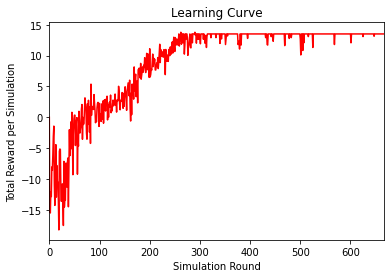

In [7]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(env.total_reward, color="red")
plt.title("Learning Curve")
plt.xlim(0, len(env.total_reward))
plt.ylabel("Total Reward per Simulation")
plt.xlabel("Simulation Round")
plt.show()

### 4. Run simulation

In [8]:
# Reset environment for simulation
state = env.reset()
done = False

# Graph data
inventory_levels = {}
for rw_id in env.simulation.get_regional_warehouses():
    inventory_levels[rw_id] = []
    
cw_inventory_level = []

# Run simulation with model
while not done:
    action, _states = trained_model.predict(state)
    state, reward, done, info = env.step(action)
    
    # For Graph
    i = 1
    for inv in info["RW Invs:"]:
        inventory_levels[i].append(inv)
        i += 1
    try:
        cw_inventory_level.append(info["CW Inv:"])
    except:
        pass
    
    # print(env.simulation.print_state())
    for i in info:
        print(i, info[i], end=" | ")
    print()
    
print("\n", env.evaluation_parameters())

Steps left: 44 | RW Invs: [8, 9] | Shipments [0, 0] | Action: [0, 0] | Reward: 0.11 | 
Steps left: 43 | RW Invs: [6, 8] | Shipments [0, 0] | Action: [0, 0] | Reward: 0.13 | 
Steps left: 42 | RW Invs: [4, 7] | Shipments [0, 0] | Action: [0, 0] | Reward: 0.16 | 
Steps left: 41 | RW Invs: [2, 6] | Shipments [1, 0] | Action: [1, 0] | Reward: -0.04 | 
Steps left: 40 | RW Invs: [0, 5] | Shipments [1, 0] | Action: [0, 0] | Reward: 0.58 | 
Steps left: 39 | RW Invs: [4, 4] | Shipments [0, 0] | Action: [0, 0] | Reward: 0.2 | 
Steps left: 38 | RW Invs: [2, 3] | Shipments [1, 0] | Action: [1, 0] | Reward: 0.02 | 
Steps left: 37 | RW Invs: [0, 2] | Shipments [1, 0] | Action: [0, 0] | Reward: 0.67 | 
Steps left: 36 | RW Invs: [4, 1] | Shipments [0, 1] | Action: [0, 1] | Reward: 0.07 | 
Steps left: 35 | RW Invs: [2, 0] | Shipments [1, 1] | Action: [1, 0] | Reward: 0.39 | 
Steps left: 34 | RW Invs: [0, 5] | Shipments [1, 0] | Action: [0, 0] | Reward: 0.58 | 
Steps left: 33 | RW Invs: [4, 4] | Shipment

###### Inventory level graphs

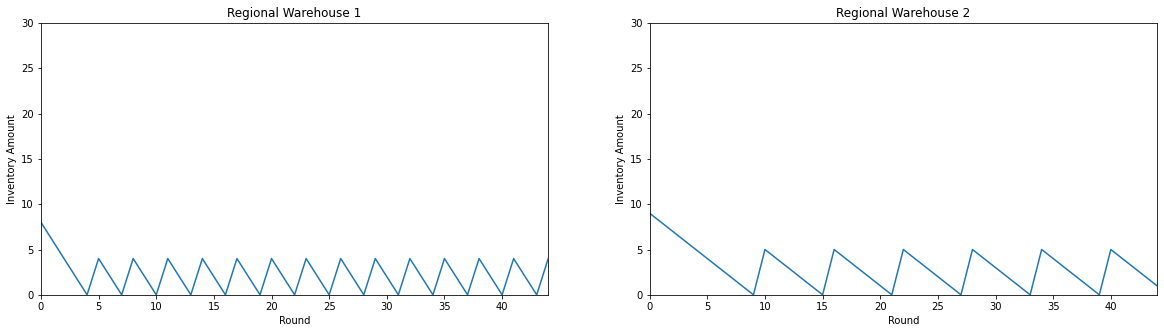

In [9]:
# Plot inventories of regional warehouses

plt.rcParams["figure.figsize"] = (20, 5)

for rw_id in inventory_levels:
    # print(inventory_levels[rw_id])
    plt.subplot(1, number_of_regional_warehouses, rw_id)
    plt.plot(inventory_levels[rw_id])
    plt.title("Regional Warehouse " + str(rw_id))
    plt.ylim(0, max_inventory_amount_regional_warehouses)
    plt.xlim(0, simulation_length-1)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")

plt.show()

In [10]:
# Plot central warehouse inventory (Only display if simulated by adding a manufacturer)
if len(cw_inventory_level) != 0:
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.plot(cw_inventory_level, color="green")
    plt.title("Central Warehouse")
    plt.ylim(0, max_inventory_amount_central_warehouse)
    plt.xlim(0, simulation_length-1)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    plt.show()